# SURF and HOG Feature Descriptors


# 1. SURF Feature Descriptors

## Overview
**SURF (Speeded-Up Robust Features)** is a robust local feature detector and descriptor. It is **scale- and rotation-invariant**, similar to SIFT, but optimized for **speed** using integral images and box filters.

---

## Mathematical Concepts Behind SURF

### a. Integral Image
SURF uses **integral images** to speed up convolution with box filters.

$$
I_{\text{int}}(x, y) = \sum_{x' \leq x, y' \leq y} I(x', y')
$$

This allows fast computation of rectangular region sums using only 4 array accesses.

(Integral image is where each pixel represents the cumulative sum of a corresponding input pixel with all pixels above and left of the input pixel. It enables rapid calculation of summations over image sub-regions.)

---

### b. Hessian Matrix-Based Keypoint Detection
SURF uses the determinant of the **Hessian matrix** to find blob-like structures.

$$
H(x, \sigma) =
\begin{bmatrix}
L_{xx}(x, \sigma) & L_{xy}(x, \sigma) \\
L_{xy}(x, \sigma) & L_{yy}(x, \sigma)
\end{bmatrix}
$$

Where $ L_{xx}, L_{xy}, L_{yy} $ are second-order Gaussian derivatives. The keypoint strength is based on the **determinant**:

$$
\text{det}(H) = L_{xx}L_{yy} - (L_{xy})^2
$$

(The Hessian Matrix is a square matrix of second ordered partial derivatives of a scalar function.)

---

### c. Orientation Assignment
A circular region around the keypoint is used. Haar wavelet responses are calculated in the x and y directions. The **dominant orientation** is assigned as the keypoint's orientation.

---

### d. Descriptor
A square region is split into $ 4 \times 4 $ subregions. For each subregion:

$$
v = \left(\sum{d_x}, \sum{|d_x|}, \sum{d_y}, \sum{|d_y|}\right)
$$

Each subregion contributes 4 values → $ 4 \times 4 \times 4 = 64 $ dimensions per descriptor.



In [ ]:
# SURF is a patented algorithm and is not available in the default OpenCV package. We can use ORB instead which works similarly
!pip install opencv-contrib-python

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def load_image(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = load_image("image12.jpg")

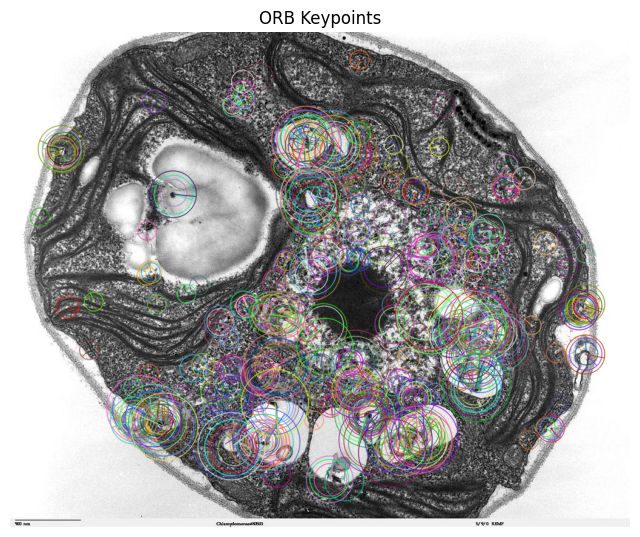

In [ ]:
orb = cv2.ORB_create()
keypoints_orb, descriptors_orb = orb.detectAndCompute(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), None)
img_orb = cv2.drawKeypoints(img, keypoints_orb, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(8, 8))
plt.imshow(img_orb)
plt.title('ORB Keypoints')
plt.axis('off')
plt.show()


# 2. HOG Feature Descriptors

## Overview
**HOG (Histogram of Oriented Gradients)** describes object shape and appearance by counting **gradient orientation occurrences** in localized image regions. It is especially effective in **object detection**, such as pedestrian recognition.

---

## Mathematical Concepts Behind HOG

### a. Gradient Computation
Image gradients are calculated using simple filters:

$$
G_x = I(x+1, y) - I(x-1, y), \quad G_y = I(x, y+1) - I(x, y-1)
$$

From which we compute:

$$
\text{Magnitude} = \sqrt{G_x^2 + G_y^2}, \quad \text{Orientation} = \tan^{-1}\left(\frac{G_y}{G_x}\right)
$$

---

### b. Spatial Binning
The image is divided into **cells** (e.g., 8x8 pixels). For each cell, a **histogram** of gradient directions is formed (typically 9 bins per cell).

---

### c. Normalization
To reduce the effects of illumination and contrast, normalization is applied over **blocks** (e.g., 2x2 cells):

$$
v = \frac{v}{\sqrt{\|v\|_2^2 + \epsilon^2}}
$$

---

### d. Descriptor
All the normalized block descriptors are **concatenated** into a single large feature vector representing the image.


In [ ]:
from skimage.feature import hog
from skimage import color

In [ ]:
# Convert image to grayscale
gray = color.rgb2gray(img)

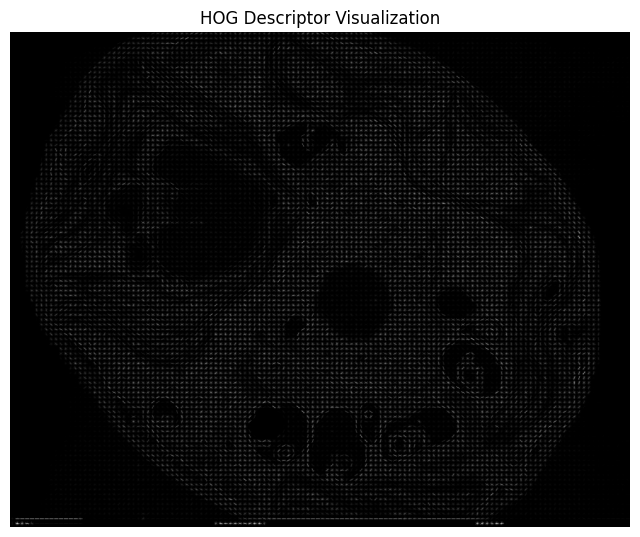

In [ ]:
# Compute HOG features and visualization
features, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=True, channel_axis=None)

plt.figure(figsize=(8, 8))
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Descriptor Visualization")
plt.axis("off")
plt.show()

# 3. Pedestrian Detection Using HOG

## Concept
HOG is widely used for **pedestrian detection** due to its robustness against changes in pose, lighting, and cluttered backgrounds.

---

## Steps

### 1. Preprocess Image
Convert the image to **grayscale** to simplify gradient computation.

### 2. Extract HOG Features
Compute HOG descriptors over **sliding windows**.

### 3. Train a Classifier
Use a **pre-trained SVM classifier**. OpenCV provides a default people detector trained using HOG.

### 4. Sliding Window + Non-Max Suppression
The image is scanned at **multiple scales** and locations. Overlapping detections are removed using **Non-Maximum Suppression**.

In [ ]:
# Detect Pedestrians using HOG
hog_detector = cv2.HOGDescriptor()
hog_detector.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

In [ ]:
img_bgr = cv2.imread("pedestrians.jpg")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

In [ ]:
# Detect people (returns bounding boxes and weights)
boxes, weights = hog_detector.detectMultiScale(img_bgr, winStride=(8, 8), padding=(8, 8), scale=1.05)


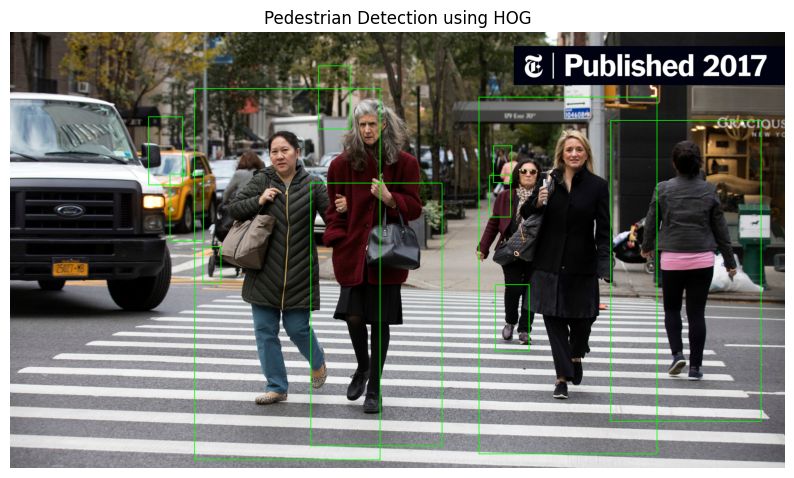

In [ ]:
# Draw bounding boxes
for (x, y, w, h) in boxes:
    cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.title("Pedestrian Detection using HOG")
plt.axis("off")
plt.show()